In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from lib import dpf, panda_models, panda_datasets, panda_training
from lib.utils import file_utils, torch_utils, misc_utils

print(torch.__version__, np.__version__)

In [27]:
# Experiment configuration
experiment_name = "push_only"
dataset_args = {
    'use_proprioception': True,
    'use_vision': True,
    'vision_interval': 10,
}

In [28]:
# Create models & training buddy

dynamics_model = panda_models.PandaSimpleDynamicsModel()
measurement_model = panda_models.PandaMeasurementModel(units=32)

pf_model = dpf.ParticleFilterNetwork(dynamics_model, measurement_model)

buddy = torch_utils.TrainingBuddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "measurement"],
    log_dir="logs/pf",
    checkpoint_dir="checkpoints/pf"
)

Using device: cuda
No checkpoint found


# Dynamics Model Training

In [17]:
dynamics_trainset = panda_datasets.PandaDynamicsDataset(
#     "data/pull-test-tiny.hdf5",
    "data/pull-test.hdf5",
    "data/push-test.hdf5",
    **dataset_args
)

Parsed data: 389533 active, 195332 inactive
Keeping: 194766


In [ ]:
dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=256, shuffle=True, num_workers=2)

for i in range(200):
    print("Training epoch", i)
    panda_training.train_dynamics(buddy, pf_model, dataloader, log_interval=10)
    print()


# Measurement Model Training

In [29]:
measurement_trainset = panda_datasets.PandaMeasurementDataset(
#     ("data/pull-test.hdf5", 10),
    ("data/push-test.hdf5", 10),
    **dataset_args
)

Progress: [####################] 100.0%
Loaded 6740 points


In [30]:
measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=512, shuffle=True, num_workers=2)
for i in range(80):
    print("Training epoch", i)
    panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=10)
    print()

Training epoch 0
...................................................................................................Saved checkpoint to path: checkpoints/pf/push_only-1000.ckpt
................................Epoch loss: 65.77838

Training epoch 1
....................................................................Saved checkpoint to path: checkpoints/pf/push_only-2000.ckpt
................................................................Epoch loss: 37.631912

Training epoch 2
....................................Saved checkpoint to path: checkpoints/pf/push_only-3000.ckpt
................................................................................................Epoch loss: 32.189957

Training epoch 3
....Saved checkpoint to path: checkpoints/pf/push_only-4000.ckpt
....................................................................................................Saved checkpoint to path: checkpoints/pf/push_only-5000.ckpt
...........................Epoch loss: 29.269676

Training e

KeyboardInterrupt: 

# End-to-end Training

In [38]:
# Create end-to-end dataset

e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    ("data/pull-test.hdf5", 10000),
    ("data/push-test.hdf5", 10000),
    subsequence_length=4,
    particle_count=50,
    particle_variances=(.2,),
    **dataset_args
)

Parsed data: 542 active, 1142 inactive
Keeping: 271


In [39]:
## Train end-to-end

e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)

pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True
pf_model.dynamics_model.state_noise = (0.1)
for i in range(100):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse")

Training epoch 0
..............................................................................Epoch loss: 0.0022687884
Training epoch 1
..............................................................................Epoch loss: 0.0014988874
Training epoch 2
..............................................................................Epoch loss: 0.0012677442
Training epoch 3
..............................................................................Epoch loss: 0.0011214123
Training epoch 4
..............................................................................Epoch loss: 0.0010588454
Training epoch 5
..............................................................................Epoch loss: 0.0009779433
Training epoch 6
..............................................................................Epoch loss: 0.0008733795
Training epoch 7
..............................................................................Epoch loss: 0.0009067239
Training epoch 8
.......................

KeyboardInterrupt: 

# Model eval

### Training set

Progress: [####################] 100.0%


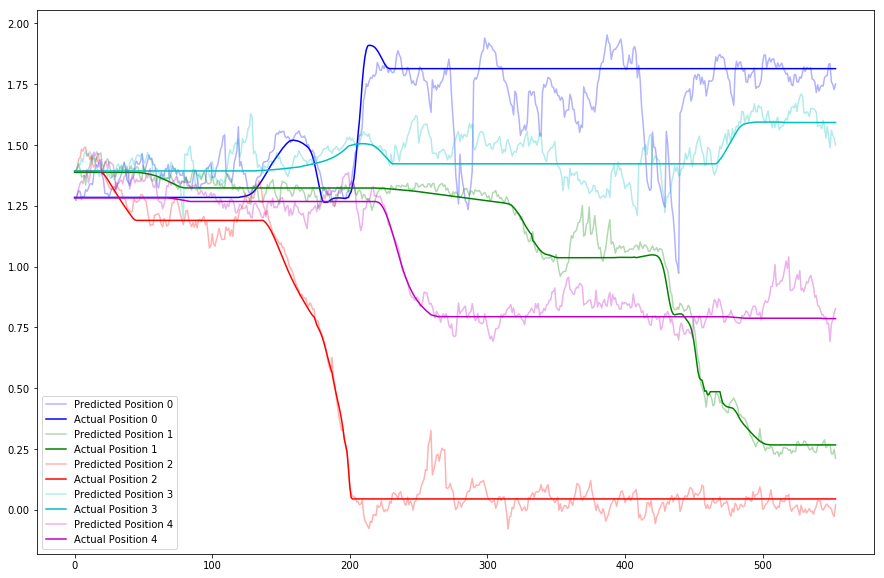

(5, 554, 1)
Position MSE:  0.008120015


In [40]:
dynamics_model.state_noise = (0.1)

eval_trajectories = panda_datasets.load_trajectories(
#     ("data/pull-test.hdf5",5),
    ("data/push-test.hdf5",5),
    **dataset_args
)
#traj = [eval_trajectories[0] for _ in range(1)]
traj = eval_trajectories[0:10]
pred, actual = panda_training.rollout(pf_model, traj, start_time=0, max_timesteps=1000, particle_count=100, noisy_dynamics=True, device=buddy._device)
panda_training.vis_rollout(pred, actual)


### Validation set

Progress: [####################] 100.0%


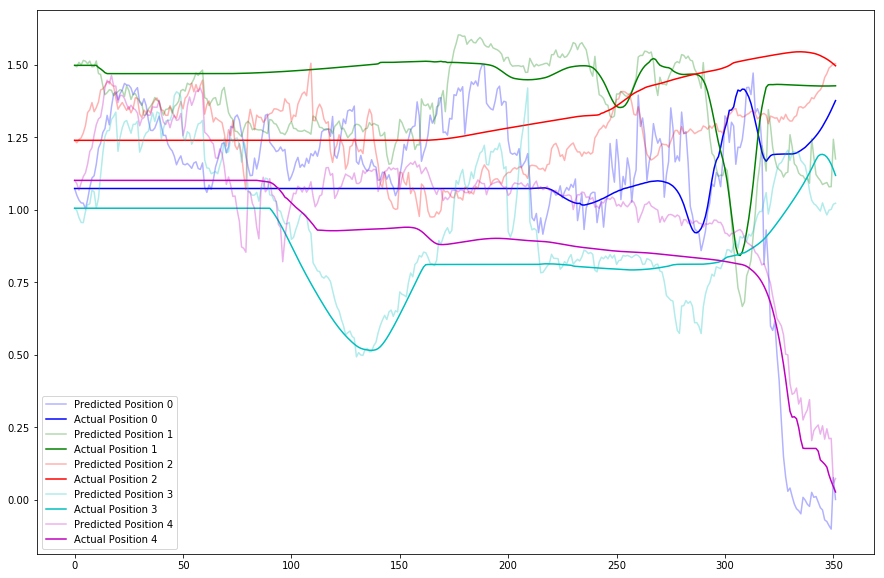

(5, 352, 1)
Position MSE:  0.051229168


In [41]:
dynamics_model.state_noise = (0.1)

eval_trajectories = panda_datasets.load_trajectories(
#     ("data/pull-test-small.hdf5",5),
    ("data/push-test-small.hdf5",5),
    **dataset_args
)
#traj = [eval_trajectories[0] for _ in range(1)]
traj = eval_trajectories
pred, actual = panda_training.rollout(pf_model, traj, start_time=0, max_timesteps=1000, particle_count=100, noisy_dynamics=True, device=buddy._device)
panda_training.vis_rollout(pred, actual)


In [30]:
### DEAD RECKONING TEST

# def eval(trajectories, max_timesteps=100000):
#     # To make things easier, we're going to cut all our trajectories to the same length :)
#     timesteps = np.min([len(s) for s, _, _ in trajectories] + [max_timesteps])
#     predicted_states = [[states[0]] for states, _, _ in trajectories]
#     actual_states = [states[:timesteps] for states, _, _ in trajectories]

#     for t in range(1, timesteps):
#         for i in range(len(trajectories)):
#             prev_state = predicted_states[i][t - 1]
#             new_vel = actual_states[i][t][1]
#             new_pos = prev_state[0] + new_vel / 20
            
#             predicted_states[i].append([new_pos, new_vel])
#         misc_utils.progress_bar(t / timesteps)
#     misc_utils.progress_bar(1.)

#     predicted_states = np.array(predicted_states)
#     actual_states = np.array(actual_states)
#     return predicted_states, actual_states


# eval_trajectories = file_utils.load_trajectories(
#     "data/pull-test-small.hdf5",   
#     use_proprioception=True,
#     use_vision=True,
#     vision_interval=1
# )
# pred, actual = eval(eval_trajectories[0:1], max_timesteps=200)
# vis_eval(pred, actual)
